In [1]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression, LogisticRegression

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- HOUSE: https://fred.stlouisfed.org/series/HSN1F
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [2]:
"""
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key
# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())


# Generate a date range from January 1950 to the present
date_range = date_range = pd.date_range(start='1950', end='2024', freq='M')

# Create Original data frame, wich Date, Year, Month columns
df_origin = pd.DataFrame({'Date': date_range})
df_origin['Year'] = df_origin['Date'].dt.year
df_origin['Month'] = df_origin['Date'].dt.month


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left')


# Download S&P500 data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()
# Add the close prices of S&P500 on each month
df_origin['SP500'] = sp500[sp500['Date'] >= '1950-01-31']['Close']

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

'\nimport yfinance as yf\nfrom fredapi import Fred\nfrom config import get_fredapi_key\n# define fred api (using my personal api key)\nfred = Fred(api_key = get_fredapi_key())\n\n\n# Generate a date range from January 1950 to the present\ndate_range = date_range = pd.date_range(start=\'1950\', end=\'2024\', freq=\'M\')\n\n# Create Original data frame, wich Date, Year, Month columns\ndf_origin = pd.DataFrame({\'Date\': date_range})\ndf_origin[\'Year\'] = df_origin[\'Date\'].dt.year\ndf_origin[\'Month\'] = df_origin[\'Date\'].dt.month\n\n\n### Data from Fred\n# list of ids and column names of monthly data\nids = [\'DGS10\', \'CPIAUCSL\', \'UMCSENT\', \'IPMAN\', \'HSN1F\', \'UNRATE\']\ncols = [\'MY10Y\', \'CPI\', \'CSENT\', \'IPM\', \'HOUSE\', \'UNEMP\']\n\n# travering all pairs of ids and cols\nfor id, col in zip(ids, cols):\n    # get the original data\n    original = fred.get_series(id)\n    # convert current index to column & change monthly data\n    df_merge = original.resample(\'M\'

In [3]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.tail()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
883,2023-08-31,2023,8,4.09,306.269,69.4,99.9799,676.0,3.8,4507.660156
884,2023-09-30,2023,9,4.59,307.481,67.9,100.3412,759.0,3.8,4288.049805
885,2023-10-31,2023,10,4.86,NaN,NaN,NaN,NaN,NaN,4117.370117
886,2023-11-30,2023,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,2023-12-31,2023,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Clearning & Modification

In [4]:
# dropping rows based on any missing data
df = df_origin.dropna()

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
265,1972-02-29,1972,2,6.04,41.4,92.8,36.2194,711.0,5.7,106.570000
268,1972-05-31,1972,5,6.05,41.6,88.6,36.9454,677.0,5.7,109.529999
271,1972-08-31,1972,8,6.42,41.9,95.2,37.5429,773.0,5.6,111.089996
274,1972-11-30,1972,11,6.28,42.4,90.7,38.8702,735.0,5.3,116.669998
277,1973-02-28,1973,2,6.64,43.0,81.9,40.3702,737.0,5.0,111.680000


Text(0.5, 1.0, 'Number of Data on Each Year.')

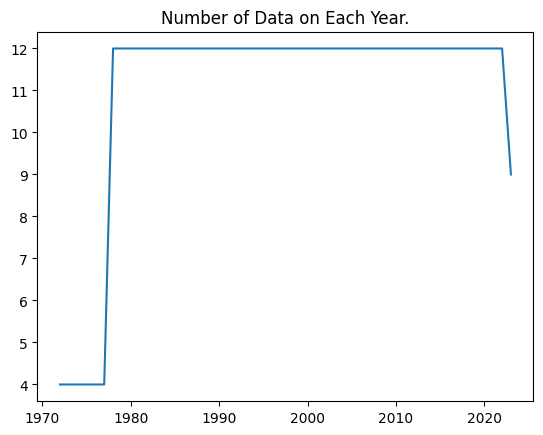

In [5]:
# groupby dataframe based on "Year" and check the count
group_year = df.groupby('Year').count()[['Date']]
plt.plot(group_year.index, group_year.values.flatten())
plt.title('Number of Data on Each Year.')

In [6]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1978-01-31,1978,1,7.94,62.7,83.7,43.7471,795.0,6.4,89.250000
1,1978-02-28,1978,2,8.04,63.0,84.3,43.9139,791.0,6.3,87.040001
2,1978-03-31,1978,3,8.15,63.4,78.8,44.6899,814.0,6.3,89.209999
3,1978-04-30,1978,4,8.24,63.9,81.6,45.3905,864.0,6.1,96.830002
4,1978-05-31,1978,5,8.42,64.5,82.9,45.6235,857.0,6.0,97.239998


In [7]:
# copy the current SP500 as SP500_Price
df['SP500_Price'] = df['SP500'].loc[:]

# Create categorical data;
#  whether the S&P500 rises (1) or falls(0) from the previous year
cat_values = (df['SP500_Price'] > df['SP500_Price'].shift(12)).astype(int)
cat_values[:12] = None
df['SP500_Rise'] = cat_values

# Changes to %YoY
chg_YoY = ['CPI', 'CSENT', 'IPM', 'HOUSE', 'SP500']
df.loc[:, chg_YoY] = df[chg_YoY].pct_change(12) * 100

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500,SP500_Price,SP500_Rise
0,1979-01-31,1979,1,8.95,9.250399,-13.859020,7.862464,-5.157233,5.9,11.966387,99.930000,1.0
1,1979-02-28,1979,2,9.17,9.841270,-12.336892,7.786828,-8.596713,5.9,10.615806,96.279999,1.0
2,1979-03-31,1979,3,9.11,10.252366,-13.197970,6.418676,-2.579853,5.8,13.877365,101.589996,1.0
3,1979-04-30,1979,4,9.35,10.485133,-19.117647,2.997984,-13.425926,5.8,5.091398,101.760002,1.0
4,1979-05-31,1979,5,9.06,10.697674,-17.852835,3.917937,-15.169195,5.6,1.892230,99.080002,1.0


In [8]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(888, 10)  ->  (537, 12)

Total Missing Valies:
827  ->  0


In [9]:
# basic statistics (original)
features = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP', 'SP500']
df_origin[features].describe()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
count,742.000000,885.000000,641.000000,621.000000,729.000000,885.000000,886.000000
mean,5.874730,122.272904,85.583619,74.246268,655.824417,5.733672,776.709221
std,2.992385,83.730383,12.880524,23.720226,208.354422,1.711406,1033.585855
min,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000,17.049999
25%,3.852500,34.700000,76.100000,50.371500,515.000000,4.400000,88.822500
50%,5.630000,110.400000,89.300000,81.839900,628.000000,5.500000,248.285004
75%,7.635000,193.600000,95.000000,98.334700,765.000000,6.800000,1211.747528
max,15.840000,307.481000,112.000000,106.420200,1389.000000,14.700000,4766.180176


In [10]:
# basic statistics (current)
df[features].describe()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,5.771248,3.522074,0.424961,1.885628,1.541610,6.114525,10.054631
std,3.389501,2.758007,13.496403,4.903644,19.985430,1.781144,15.914452
min,0.550000,-1.958761,-41.520468,-19.513084,-50.534759,3.400000,-44.756241
25%,2.940000,1.897448,-6.589958,-0.241347,-10.873016,4.800000,2.044136
50%,5.070000,2.843915,0.281690,2.353977,2.729885,5.700000,11.739275
75%,8.020000,4.129264,6.723586,4.722677,13.576159,7.200000,19.609019
max,15.840000,14.592275,47.582205,20.819818,88.200590,14.700000,53.714506


# Data Observation

### Correlation Matrix

In [11]:
# correlation Matrix
df[features].corr()

,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
MY10Y,1.000000,0.592219,0.131505,0.159661,-0.106524,0.281223,0.040169
CPI,0.592219,1.000000,-0.229663,0.023801,-0.361605,0.008175,-0.019967
CSENT,0.131505,-0.229663,1.000000,0.298721,0.404598,0.174768,0.419536
IPM,0.159661,0.023801,0.298721,1.000000,0.133935,-0.237187,0.397708
HOUSE,-0.106524,-0.361605,0.404598,0.133935,1.000000,0.138328,0.379114
UNEMP,0.281223,0.008175,0.174768,-0.237187,0.138328,1.000000,0.024833
SP500,0.040169,-0.019967,0.419536,0.397708,0.379114,0.024833,1.000000


### Feature Reduction

In [12]:
# create a new feature and insert it 
df.insert(loc=9, column='LRIR', value=df['MY10Y'] - df['CPI'])

# drop MY10Y and CPI
df.drop(['MY10Y', 'CPI'], axis=1, inplace=True)

# show new dimension
print("New Dimension: ", df.shape)

# show new correlation matrix
features = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR', 'SP500']
df[features].corr()

New Dimension:  (537, 11)


,CSENT,IPM,HOUSE,UNEMP,LRIR,SP500
CSENT,1.000000,0.298721,0.404598,0.174768,0.380992,0.419536
IPM,0.298721,1.000000,0.133935,-0.237187,0.167885,0.397708
HOUSE,0.404598,0.133935,1.000000,0.138328,0.224626,0.379114
UNEMP,0.174768,-0.237187,0.138328,1.000000,0.328568,0.024833
LRIR,0.380992,0.167885,0.224626,0.328568,1.000000,0.067510
SP500,0.419536,0.397708,0.379114,0.024833,0.067510,1.000000


### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


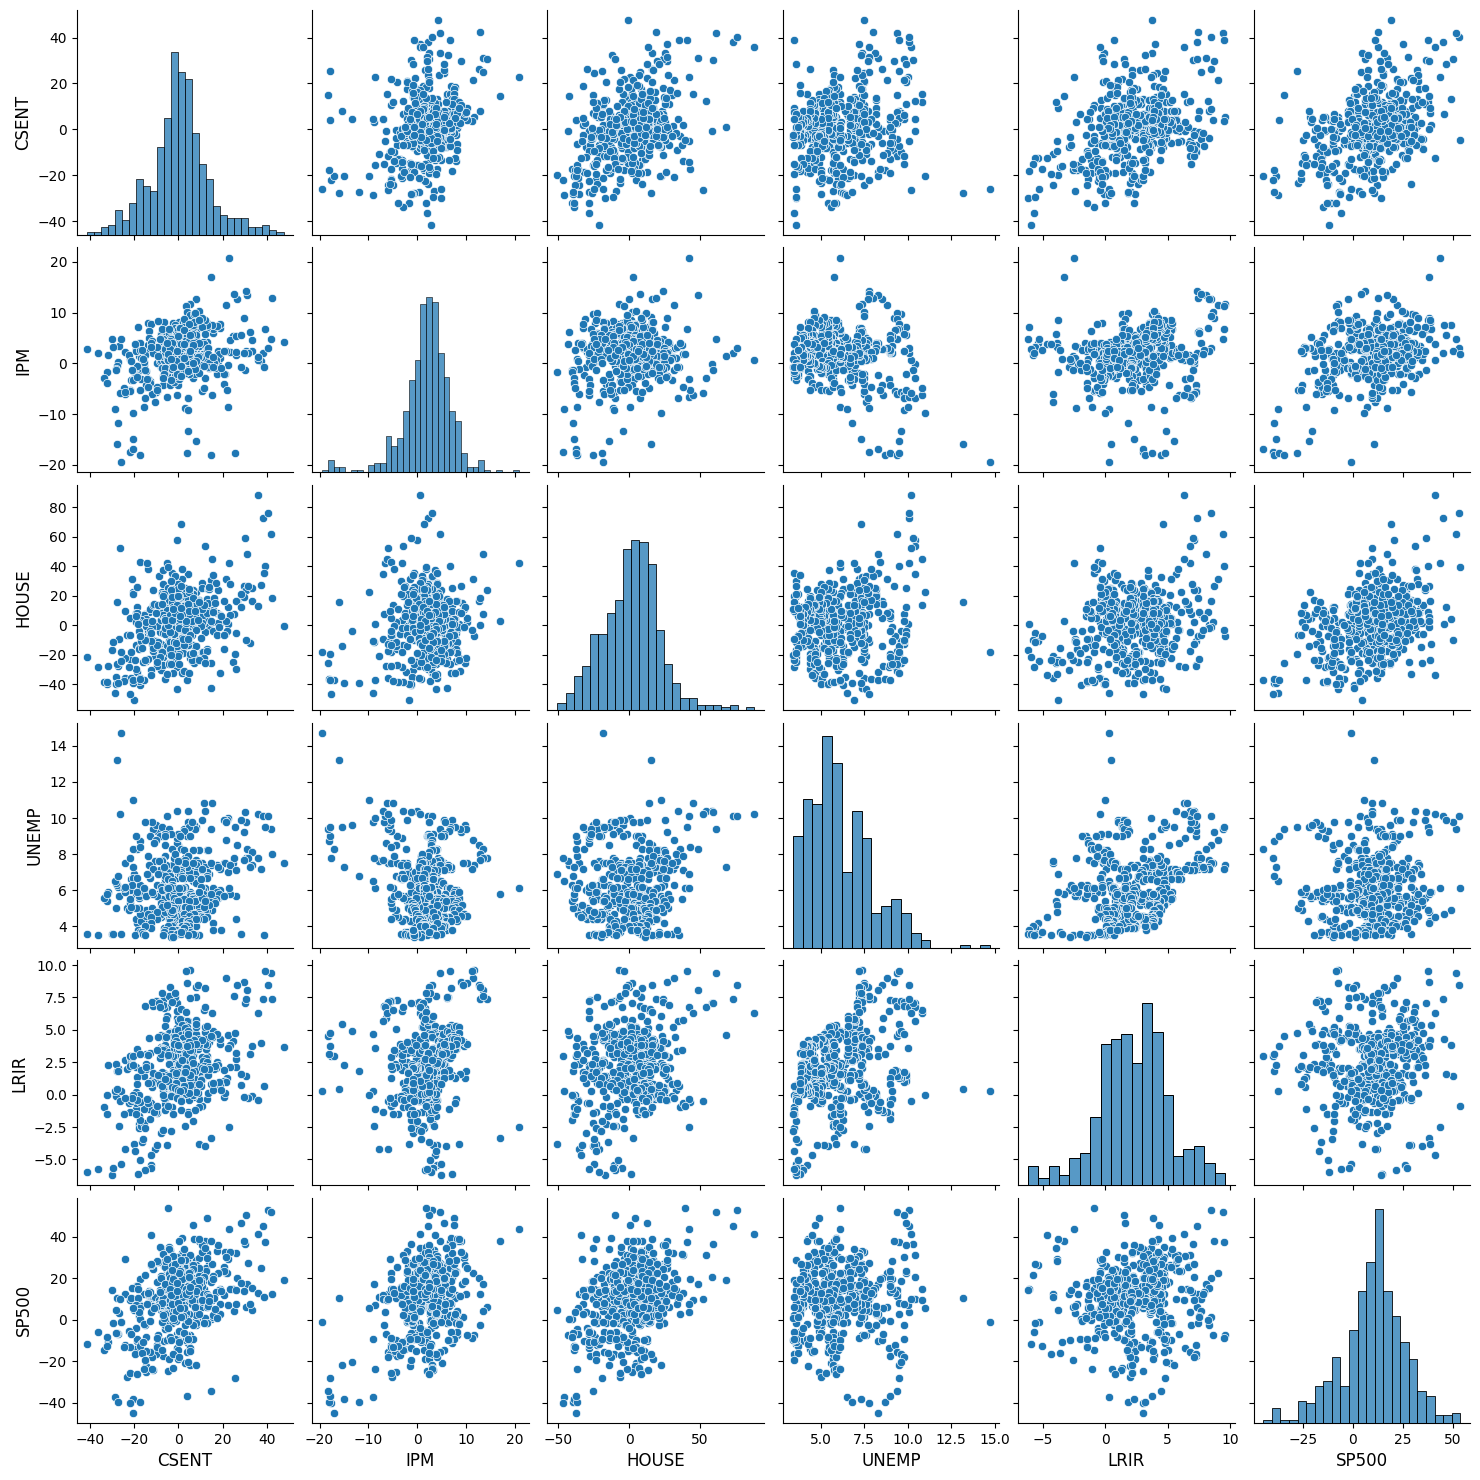

In [13]:
# check correlation 
corr_plot = sns.pairplot(df[features])

for ax in corr_plot.axes.flatten():
    # Set x-axis label
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    # Set y-axis label
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')

plt.show()

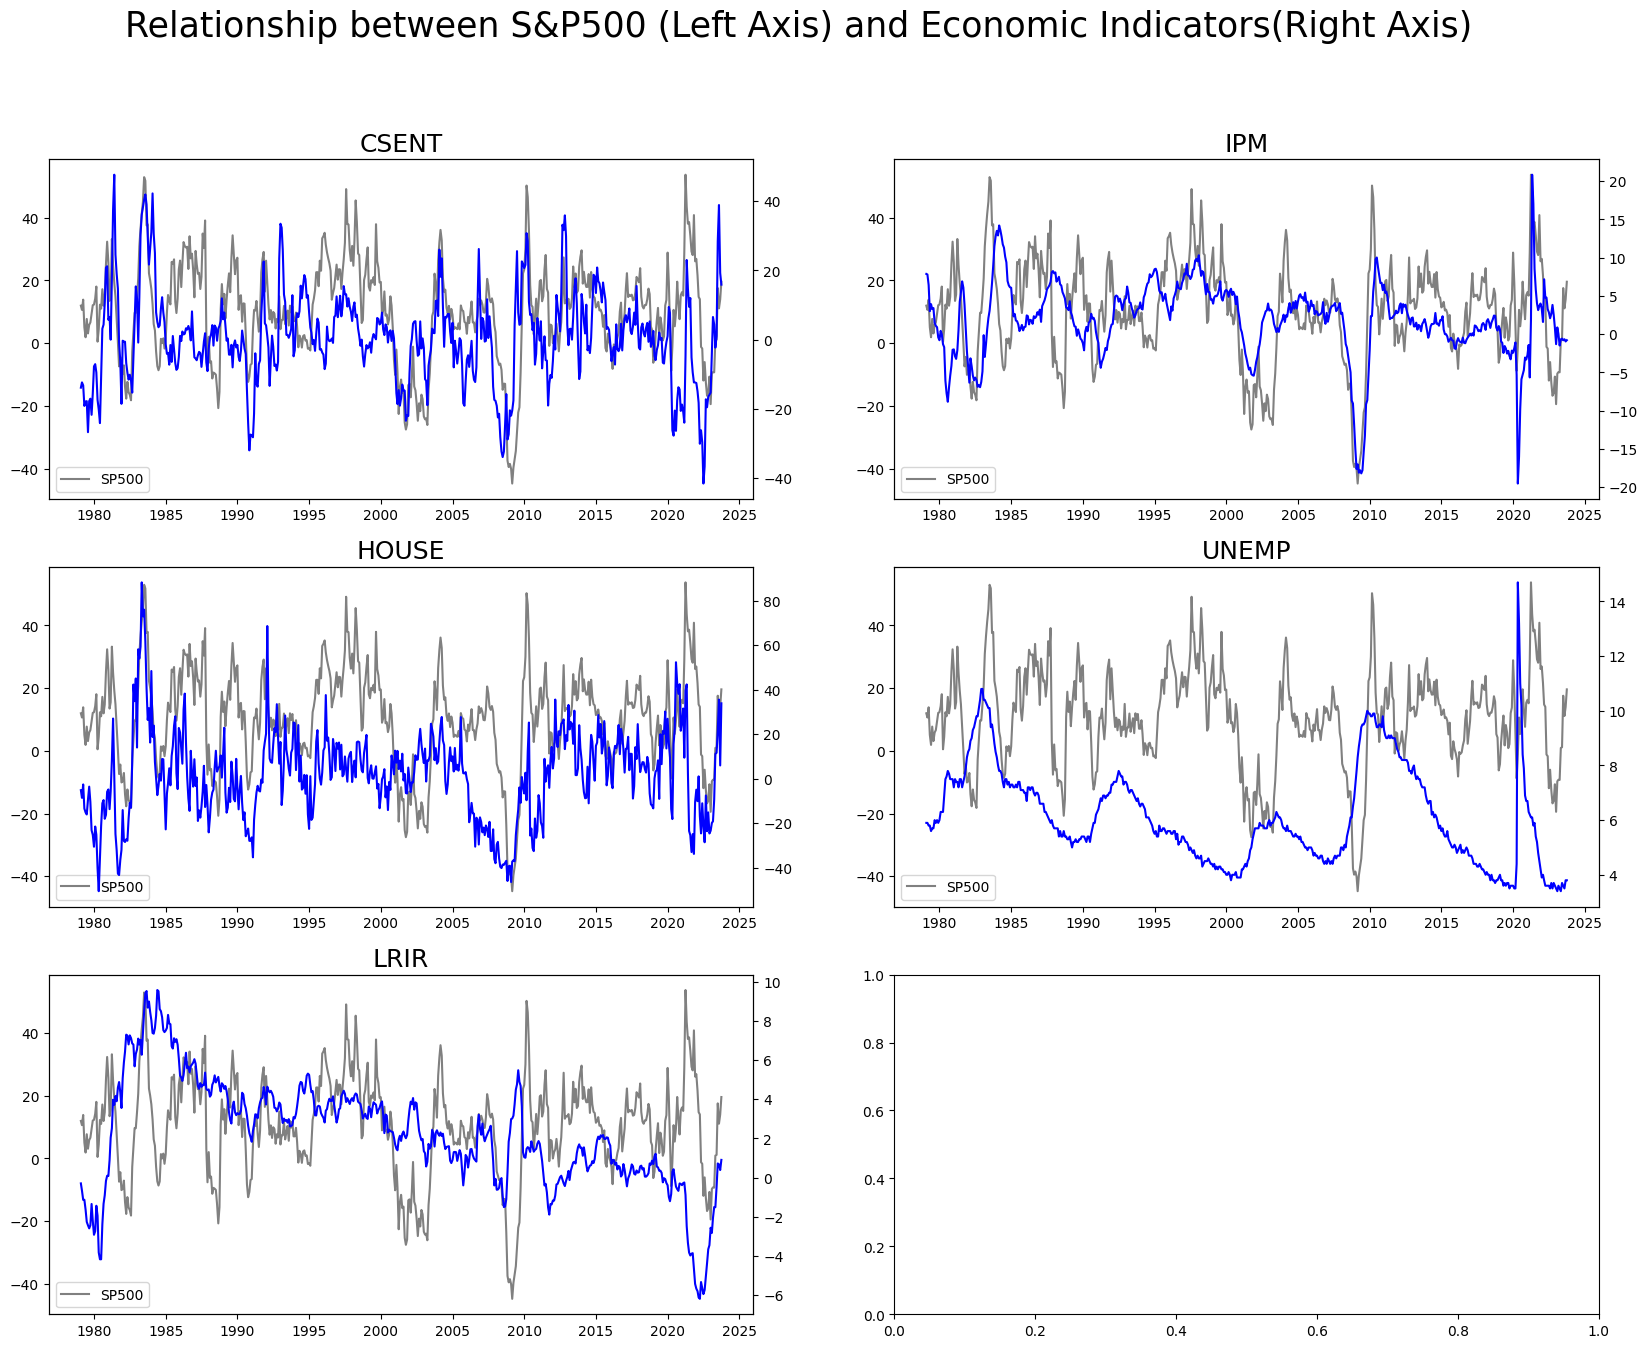

In [73]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))
fig.suptitle('Relationship between S&P500 (Left Axis) and Economic Indicators(Right Axis)', fontsize=25)

for idx, d in enumerate(features[:-1]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"{d}", fontsize=18)
    ax[i][j].legend()


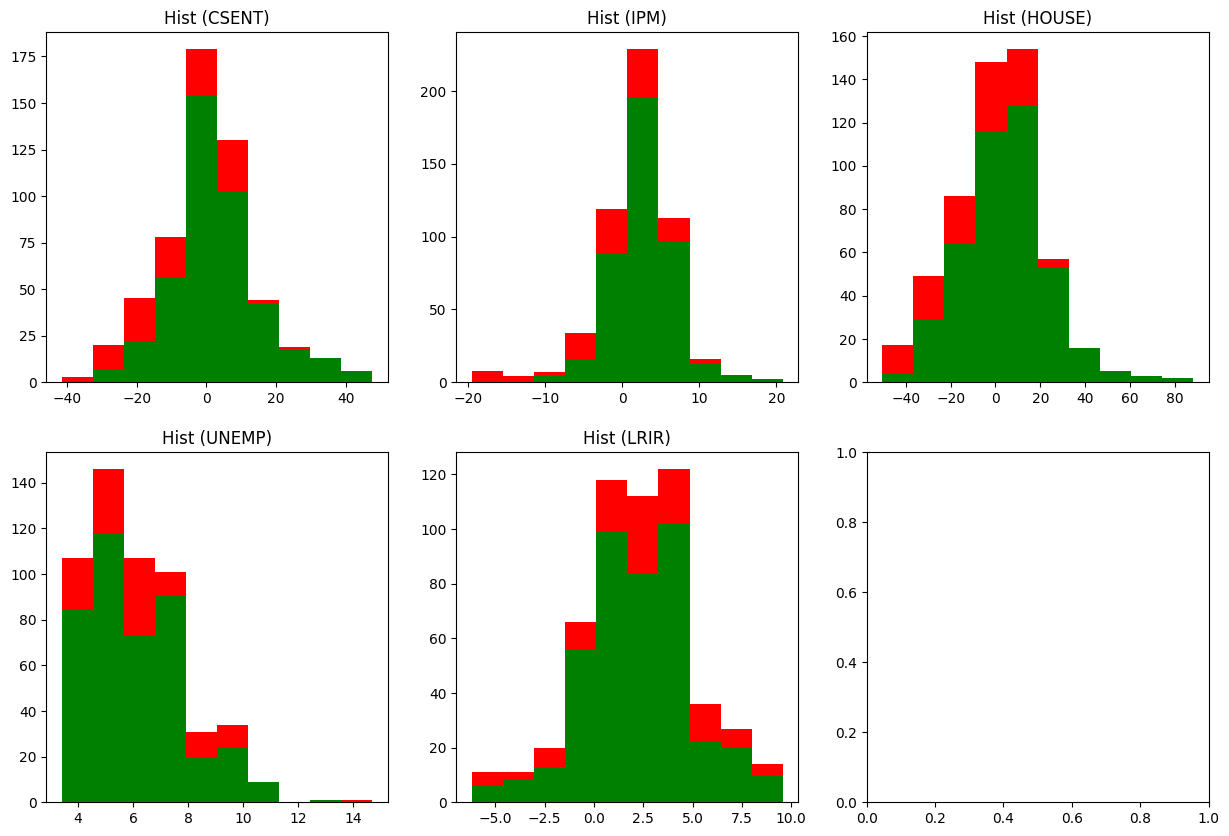

In [77]:
# Check histogram of each independent variable based on the ratio of categorical data.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, data in enumerate(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']):
    i1, i2 = i // 3, i % 3
    rise = df[df['SP500_Rise'] == 1.0][data]
    fall = df[df['SP500_Rise'] == 0.0][data]
    ax[i1][i2].hist([rise, fall], color=['green', 'red'], stacked=True)
    ax[i1][i2].set_title(f'Hist ({data})')


C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


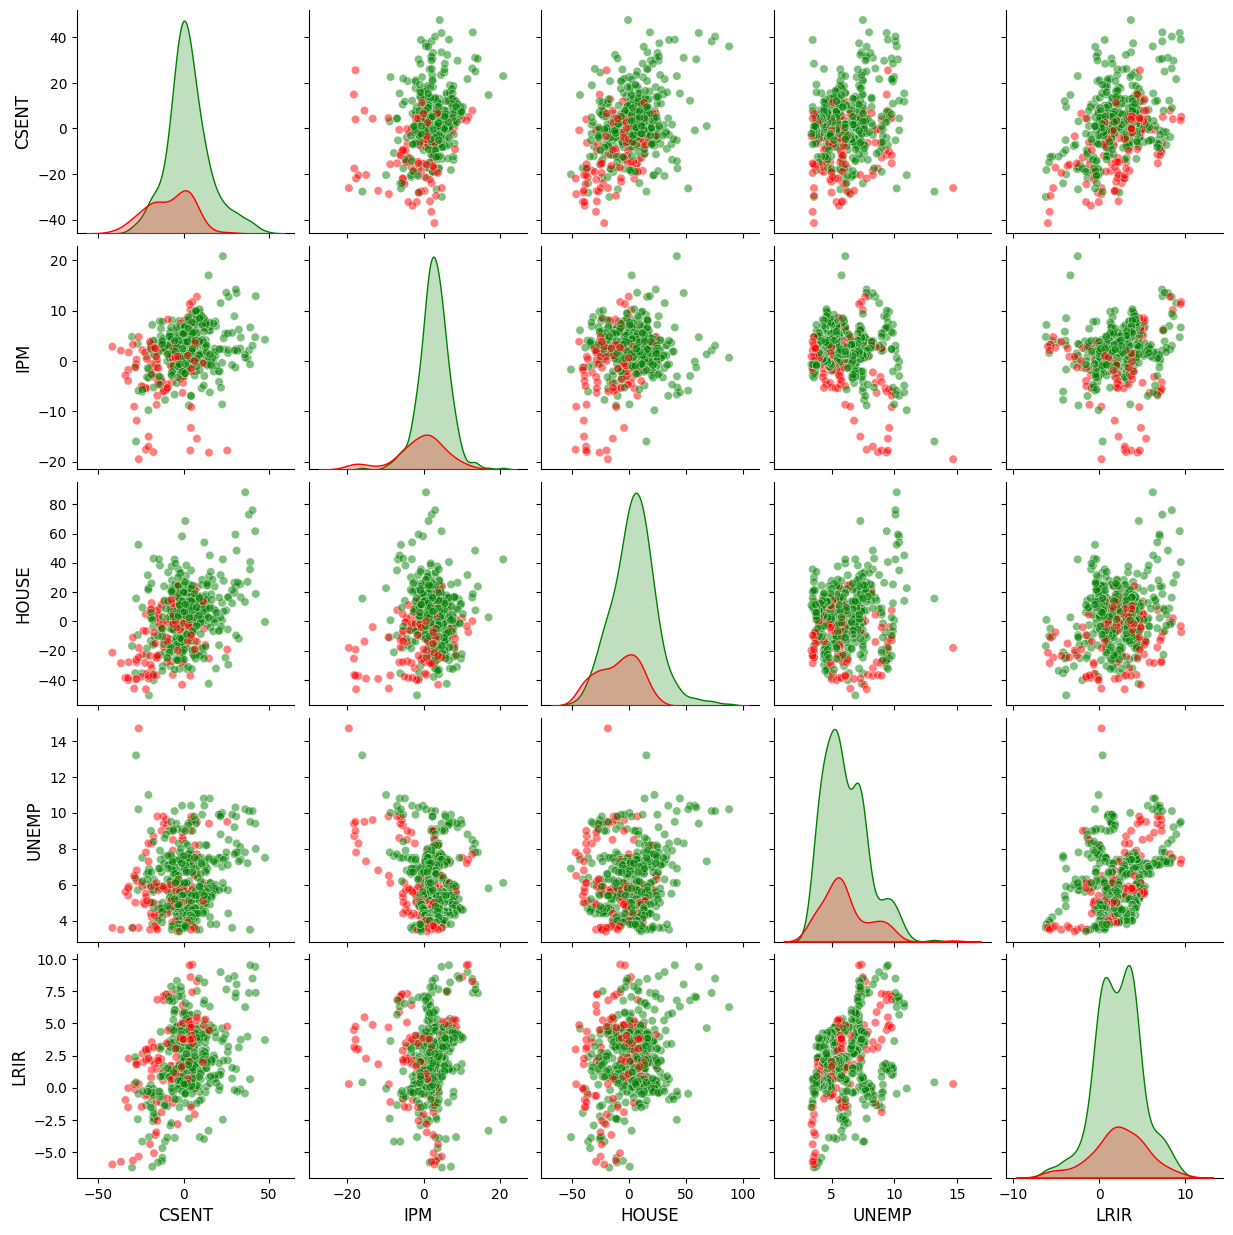

In [81]:
# Check the pairs (two independent variables) of the scatter plots based on the categorical data.
indicators = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

corr_plot2 = sns.pairplot(df[indicators + ['SP500_Rise']], hue='SP500_Rise', 
                          plot_kws={'alpha': 0.5}, palette={1: "green", 0: "red"})


# Remove the existing legend
corr_plot2._legend.remove()

for ax in corr_plot2.axes.flatten():
    # Set x-axis label
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    # Set y-axis label
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')

# Dataset Creation
- Six types of moving averages ; from one to six months.
- Six types of dataset shifts; from one to six months.


In [14]:
from Functions import PredictiveAnalysis

PA = PredictiveAnalysis(df)
PA.create_data(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR'], 'SP500', ma=[1,2,3,4,5,6], fp=[1,2,3,4,5,6], poly_d=1)

In [15]:
# check the format of each X and y matrix
print(PA.datasets['1MA_1FP']['X'][:5])
print(PA.datasets['1MA_1FP']['y'][:5])
print(PA.datasets['1MA_1FP']['y_cat'][:5])

[[ 1.         -1.07697478  1.02863002 -0.24524403 -1.02032316 -1.34994328]
 [ 1.         -0.97845534  1.01416757 -0.38013943 -1.02032316 -1.45430278]
 [ 1.         -1.0341884   0.75256061 -0.14415995 -1.09159136 -1.58686461]
 [ 1.         -1.41733832  0.09848356 -0.56953973 -1.09159136 -1.58482934]
 [ 1.         -1.3354736   0.2743895  -0.63791022 -1.23412778 -1.72623957]]
[[10.61580626]
 [13.87736507]
 [ 5.09139751]
 [ 1.89222954]
 [ 7.7253271 ]]
[[1]
 [1]
 [1]
 [1]
 [1]]


# Model Creation & Evaluation

- Four machine learning models
    1. Multiple Linear Regression
    3. Logistic Regression
    4. Classification and Regression Tree

<br>

- Evaluations
    - Regressions:
        - <b>Root Mean Square Error (RMSE)</b>: How much errors could occur between the predicted prices and the actual ones.
        - <b>Standard Error of Estimate (SE)</b>: How much variation could occur in the actual target based on the same condition of independent variables. 
        - <b>Coffeficient of Determination (R2)</b>: How well the regression model explains the variation of a target value.<br><br>
        
    - Classification
        - <b>Accuracy</b>: How the model can correctly predict the target values.
        - <b>Precision</b>: How the model can avoid false positives.
        - <b>Recall</b>: How the model can avoid false negatives.
        - <b>F1 Score</b>: How the model can balance precision and recall.
        - <b>ROC (Receiver Operating Characteristic)</b>: How the model can trade off between true positives and false positives.
        - <b>AUC (Area Under the ROC Curve)</b>: How the model can summarize the ROC curve.

### Multiple linear Regression
- Applying different scopes for parameter adjustments; [1,2,3,4,5,6]
- Feature selection by backward elimination for whole models.

In [16]:
fig1_1, fig1_2, fig1_3 = PA.linear_reg(scopes=[1,2,3,4,5,6], model_name='Linear')

fig1_1.show()
fig1_2.show()
fig1_3.show()

In [17]:
fig2_1, fig2_2 = PA.detail_perf(ma=3, fp=3, sc=6)
fig2_1.show()
fig2_2.show()

In [20]:
for i in PA.futures.keys():
    for j in PA.futures[i].keys():
        if j == '1MA':
            yoy_mean = np.mean(PA.futures[i][j], axis=0)
            #print("YoY: ", yoy_mean)
            r = 12 - int(i[0])
            act_prices = df['SP500_Price'][-12:-r].values * (yoy_mean/100+1)
            print(act_prices)
            print('')

[4519.30141611]

[4217.61923621 4796.55396071]

[4711.70418087 4480.50920302 4524.63232582]

[4406.1236271  4817.60087469 4182.24727927 4732.75597993]

[4231.93494587 4618.37599184 4506.22183048 4422.91071849 4613.20127831]

[4244.3012318  4471.80071283 4298.43828082 4725.53811383 4273.11082065
 4749.50356939]



In [111]:
PA.results['1FP']['1MA_1SC']['y_hat'].shape

(416, 1)

### Logistic Regression

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier

In [204]:
X = PA.datasets['1MA_1FP']['X']
y = PA.datasets['1MA_1FP']['y_cat']
X.shape, y.shape

((537, 6), (536, 1))

In [393]:
def sigmoid(h):
    return 1 / (1 + np.exp(-h))

def gradient(X, y, theta, w, alpha_, lambda_):
    m = len(y)
    preds = sigmoid(np.dot(X, theta.reshape(-1,1)))
    grad = -np.dot(X.T, np.multiply(y - preds, w)) / m
    l1 = lambda_ * np.sign(theta)
    l2 = (1 - lambda_) * theta

    return grad.T + alpha_ * (l1 + l2)

#sgd_logit = SGDClassifier(loss='log_loss', penalty='elasticnet', 
#                          alpha=0.001, l1_ratio=0.5, fit_intercept=False, max_iter=100,
#                          class_weight='balanced', warm_start=True)
#sgd_logit.fit(X[:120], y[:120].flatten())
#y_pred = sgd_logit.predict(X[120:len(y)])

logit = LogisticRegression(fit_intercept=False, class_weight='balanced')
logit.fit(X[:120], y[:120].flatten())
y_pred = logit.predict(X[120:len(y)])

print("Initial")
print(accuracy_score(y[120:], y_pred))
print(confusion_matrix(y[120:], y_pred))
print('')

# define variables
thetas = np.zeros((len(y[120:])+1, 6))
y_pred_c = np.zeros((len(y[120:]), 1), dtype=int)
y_pred_p = np.zeros((len(y[120:]), 2))
errors = np.zeros((len(y[120:]), 1))
weights = {u: 531 / (2*np.bincount(y.flatten())[u]) for u in np.unique(y)}
# set initial parameter
thetas[0] = logit.coef_

# define all hyperparamter
num_iter = 100
eta_ = 0.001  # learning rate
alpha_ = 0.1  # regularization strength
lambda_ = 0.5  # l1 and l2 balancer

# define the vectorized function to converting each class to its weight
vfunc_weights = np.vectorize(lambda x: weights[x])

# start incremental learning
scope = 6
for idx, i in enumerate(range(120, len(y), 1)):
    # apply sigmoid function
    y_hat = sigmoid(np.dot(X[i:i+1], thetas[idx]))
    # predicted label
    y_pred_c[idx] = np.array([1 if y_hat >= 0.5 else 0])
    # predicted probability
    y_pred_p[idx] = np.array([1-y_hat, y_hat]).reshape(1, -1)
    # actual value
    y_act = y[i][0]
    # logistic loss
    errors[idx] = -1 * weights[y_act] * np.log(y_pred_p[idx][y_act])

    # subset pf X and y
    X_sub, y_sub = X[i+1-scope: i+1], y[i+1-scope: i+1]
    # update parameter
    theta_epoch = thetas[idx]
    for i in range(num_iter):
        # get the partial derivative
        grad = gradient(X_sub, y_sub, theta_epoch, vfunc_weights(y_sub), alpha_, lambda_)
        # update the theta
        #print(grad.shape)
        theta_epoch -= eta_* grad.flatten()

    # finally update the theta
    thetas[idx+1] = theta_epoch
    

print('Increment: ')
print(accuracy_score(y[120:], y_pred_c))
print(confusion_matrix(y[120:], y_pred_c))

Initial
0.7091346153846154
[[ 29  61]
 [ 60 266]]

Increment: 
0.8245192307692307
[[ 63  27]
 [ 46 280]]


To understand the partial derivative in each step of the parameter update in Stochastic Gradient Descent (SGD) for logistic regression, let's break down the process:

### Parameters in Logistic Regression
In logistic regression, the prediction model is given by the sigmoid function:
\[ \sigma(z) = \frac{1}{1 + e^{-z}} \]
where \( z = \mathbf{w}^T \mathbf{x} \) is the linear combination of the weights \( \mathbf{w} \) and the input features \( \mathbf{x} \).

### Cost Function
The cost function in logistic regression (using log loss) is:
\[ J(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^{N}[y_i \log(\sigma(\mathbf{w}^T \mathbf{x}_i)) + (1-y_i)\log(1-\sigma(\mathbf{w}^T \mathbf{x}_i))] \]

### Gradient of the Cost Function
The gradient of the cost function with respect to the weights \( \mathbf{w} \) is needed for the SGD update. The partial derivative of \( J \) with respect to each weight \( w_j \) is:
\[ \frac{\partial J}{\partial w_j} = -\frac{1}{N} \sum_{i=1}^{N} [x_{ij} (y_i - \sigma(\mathbf{w}^T \mathbf{x}_i))] \]

### Parameter Update in SGD
In each iteration of SGD, the weights are updated as follows:
\[ \mathbf{w} = \mathbf{w} - \eta \nabla J(\mathbf{w}) \]
where \( \eta \) is the learning rate.

### Elastic Net Regularization
When using Elastic Net, the regularization term is added to the cost function. The Elastic Net penalty can be expressed as:
\[ P(\mathbf{w}) = \alpha \|\mathbf{w}\|_1 + \frac{1-\alpha}{2} \|\mathbf{w}\|^2_2 \]

The partial derivative of the Elastic Net penalty with respect to \( w_j \) is:
\[ \frac{\partial P}{\partial w_j} = \alpha \cdot \text{sign}(w_j) + (1 - \alpha) \cdot w_j \]

### Combined Update Rule
The final update rule, combining the gradient of the loss and the regularization term, is:
\[ w_j = w_j - \eta \left( \frac{\partial J}{\partial w_j} + \frac{\partial P}{\partial w_j} \right) \]

This is the mathematical formulation of how each weight in the logistic regression model is updated using SGD with Elastic Net regularization. It balances between fitting the model to the data and maintaining the model's simplicity to avoid overfitting.

0.9760891639118573

# Memo

RMSE: 8.5643%


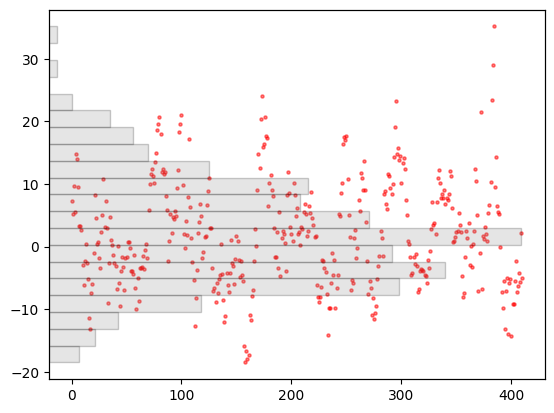

In [ ]:
data_name = '3MA_2M'
model = 'online'

data = datasets[data_name]
theta, y_hat, error = tuple(linear_reg[model][data_name].values())

print(f"RMSE: {np.sqrt(sum(error**2) / len(error))[0]:.4f}%")

#plt.plot(y_hat, label='Prediction')
#plt.plot(data['y'][-len(y_hat):], label='Actual')
plt.scatter(range(len(error)), error, alpha=0.5, s=5, color='red', label='Error')
#plt.title(f'Model Performance vs Error Distribution\nMean: {error.mean():.4f} Std: {error.std():.4f}')
#plt.xlabel('Time Periods (Month)')
#plt.ylabel('YoY Growth (%)')
#plt.legend()

ax2 = plt.twiny()
ax2.hist(error, orientation='horizontal', bins=20, 
         alpha=0.2, color='grey', edgecolor='black')
ax2.xaxis.set_visible(False)

In [ ]:
# define column names for independent variables
x_cols = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

model = LinearRegression()

# predicted %YoY growths after each month based on the last 10 years data
date = df['Date'].iloc[120:].values
est_growth = {'0M': [],'1M': [np.nan], '2M': [np.nan]*2, '3M': [np.nan]*3}
future = {'0M': [], '1M': [], '2M': [], '3M': []}
# test data index

for m in [0,1,2,3]:
    # shift data for each month
    df_shift = df.copy()
    df_shift['SP500'] = df['SP500'].shift(-m)
    # create train and test data
    for i in range(120, len(df)-m):
        # define start index
        s = i - 120
        train = df_shift.iloc[s:i]
        test = df_shift.iloc[i:i+1]

        # define model
        model = LinearRegression()
        # fit the data
        model.fit(train[x_cols], train['SP500'])
        # get and predicted value and store it to dict
        est_growth[f'{m}M'] += list(model.predict(test[x_cols]))
    
    # add the rest of feature(s)
    future[f'{m}M'] += list(model.predict(df_shift.iloc[-m:][x_cols])) 

In [ ]:
result_df = df[['Date', 'SP500']].iloc[120:].reset_index(drop=True)
# add predicted growth
for k in est_growth.keys():
    result_df[f"Est_{k}_Ago"] = est_growth[k]
result_df.head()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
0,1989-01,15.715561,NaN,NaN,NaN
1,1989-02,7.856014,24.660302,NaN,NaN
2,1989-03,13.897786,12.531227,22.899435,NaN
3,1989-04,18.486217,9.114212,11.757725,22.306831
4,1989-05,22.261209,11.153234,8.972035,11.393356


In [ ]:
result_df.tail()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
411,2023-04,0.908772,2.687153,3.438394,2.489983
412,2023-05,1.153883,5.561697,2.336005,4.000293
413,2023-06,17.567590,6.732435,5.110040,3.151268
414,2023-07,11.105029,11.939503,7.009820,5.578984
415,2023-08,13.973708,15.989454,11.825849,7.337735


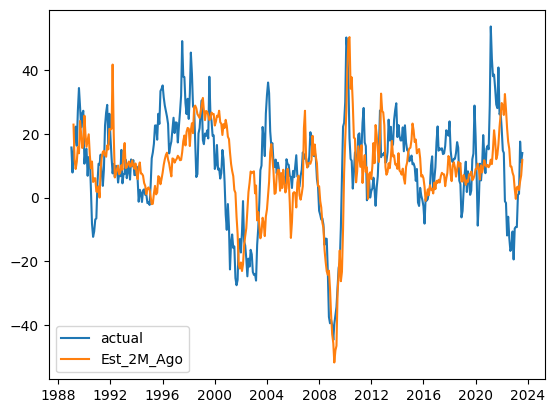

In [ ]:
plt.plot(pd.to_datetime(result_df['Date']), result_df['SP500'], label='actual')
plt.plot(pd.to_datetime(result_df['Date']), result_df['Est_2M_Ago'], label='Est_2M_Ago')
plt.legend()

In [ ]:
future

{'1M': [8.674979625958029],
 '2M': [15.35483201095332, 8.707772307491057],
 '3M': [13.59716455647952, 17.544255000982595, 10.17739639106059]}

In [ ]:
for a, b in zip([3585.620117, 3871.979980, 4080.110107], future):
    growth = (b/100) + 1
    print(a*growth)


3896.671931614002
4209.143180450038
4495.359085781116
